In [184]:
import warnings
warnings.filterwarnings('ignore')

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [186]:

file = '../seafood_data_junho/전복.csv'


In [187]:
file = pd.read_csv(file)

In [188]:
df = pd.DataFrame(file)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32066 entries, 0 to 32065
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      32066 non-null  object
 1   어종      32066 non-null  object
 2   산지      32066 non-null  object
 3   규격      32066 non-null  object
 4   포장      32066 non-null  object
 5   수량      32066 non-null  object
 6   중량      32066 non-null  object
 7   평균가     32066 non-null  object
dtypes: object(8)
memory usage: 2.0+ MB


In [86]:
df.columns

Index(['날짜', '어종', '산지', '규격', '포장', '수량', '중량', '평균가'], dtype='object')

In [87]:
df.columns = ['date', 'species', 'origin', 'standard', 'unit', 'amount', 'weight', 'avg_price']

In [88]:
df.describe()

,date,species,origin,standard,unit,amount,weight,avg_price
count,32066,32066,32066,32066,32066,32066,32066,32066
unique,1533,4,18,107,7,511,12,619
top,2018-08-13,(활)전복,완도,12/13미,kg,11,1,"23,000"
freq,40,31517,31880,1621,31844,1600,32020,1023


In [89]:
df.head()

,date,species,origin,standard,unit,amount,weight,avg_price
0,2017-01-02,(활)전복,완도,10/11미,kg,78,1,"43,100"
1,2017-01-02,(활)전복,완도,11/12미,kg,33,1,"40,200"
2,2017-01-02,(활)전복,완도,12/13미,kg,145,1,"37,700"
3,2017-01-02,(활)전복,완도,12미,kg,35,1,"35,000"
4,2017-01-02,(활)전복,완도,13/14미,kg,124,1,"36,100"


## 데이터타입 변환

In [90]:
df = df[df.date != '날짜']

### 평균가에 , 기호 없애기

In [91]:
df['avg_price'] = df.avg_price.str.replace(',', '').astype('int')

### 중량에 , 기호 없애기 (중량 float로 변환)

In [92]:
# df['weight'] = df.avg_price.str.replace(',', '').astype('float')
df['weight'] = df['weight'].astype('float')

### 수량에 , 기호 없애기

In [93]:
df['amount'] = df.amount.str.replace(',', '').astype('int')

In [94]:
df.dtypes

date          object
species       object
origin        object
standard      object
unit          object
amount         int32
weight       float64
avg_price      int32
dtype: object

### 날짜 데이터 년, 월, 일로 나누고 int형으로 변환

In [95]:
df['yyyy'], df['mm'], df['dd'] = df['date'].str.split('-').str

In [96]:
df.head()

,date,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd
0,2017-01-02,(활)전복,완도,10/11미,kg,78,1.0,43100,2017,01,02
1,2017-01-02,(활)전복,완도,11/12미,kg,33,1.0,40200,2017,01,02
2,2017-01-02,(활)전복,완도,12/13미,kg,145,1.0,37700,2017,01,02
3,2017-01-02,(활)전복,완도,12미,kg,35,1.0,35000,2017,01,02
4,2017-01-02,(활)전복,완도,13/14미,kg,124,1.0,36100,2017,01,02


In [97]:
df = df.drop('date', axis=1)

In [98]:
for i in ['yyyy', 'mm', 'dd']:
  df[i] = list(map(int, df[i]))

In [99]:
df.dtypes

species       object
origin        object
standard      object
unit          object
amount         int32
weight       float64
avg_price      int32
yyyy           int64
mm             int64
dd             int64
dtype: object

#### 년 / 월 / 일 별 가격변동

<AxesSubplot:xlabel='dd'>

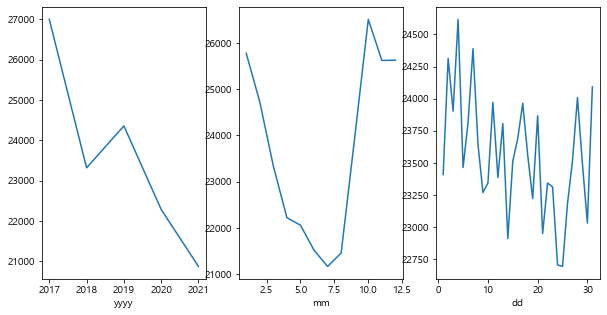

In [100]:
plt.figure(figsize=(10, 5))

plt.subplot(131)
Years = df.groupby('yyyy').mean()
Years['avg_price'].plot(x=df.yyyy)
plt.subplot(132)
Months = df.groupby('mm').mean()
Months['avg_price'].plot(x=df.mm)
plt.subplot(133)
Days = df.groupby('dd').mean()
Days['avg_price'].plot(x=df.dd)

#### 산지별 가격분포

Text(0, 0.5, 'origin')

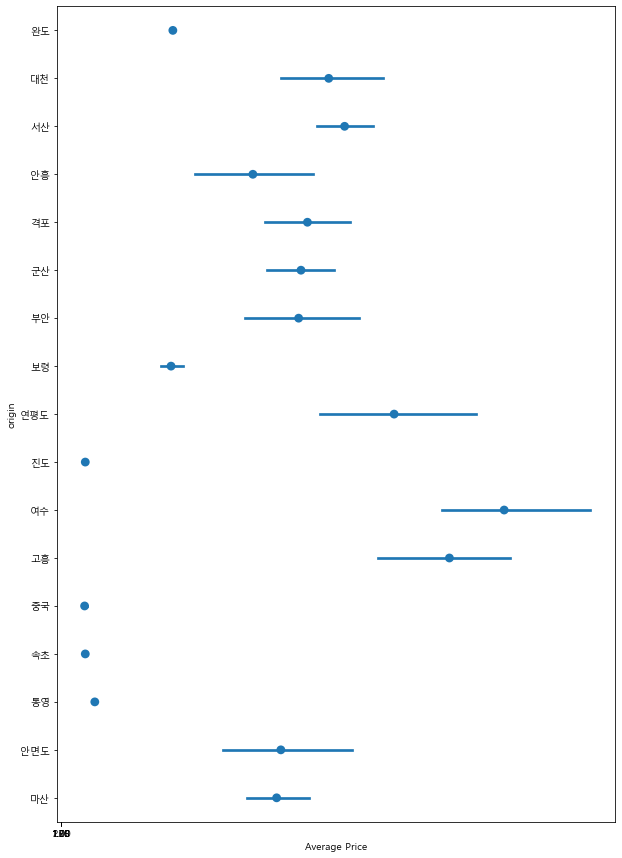

In [101]:
plt.rcParams['font.family']= 'Malgun Gothic'

plt.figure(figsize=(10, 15))
sns.pointplot(x='avg_price', y='origin', data=df, join=False)
plt.xticks(np.linspace(1, 2, 5))
plt.xlabel('Average Price')
plt.ylabel('origin')

In [102]:
jb_pdf = df[df.species=='(활)전복']

Text(0, 0.5, 'origin')

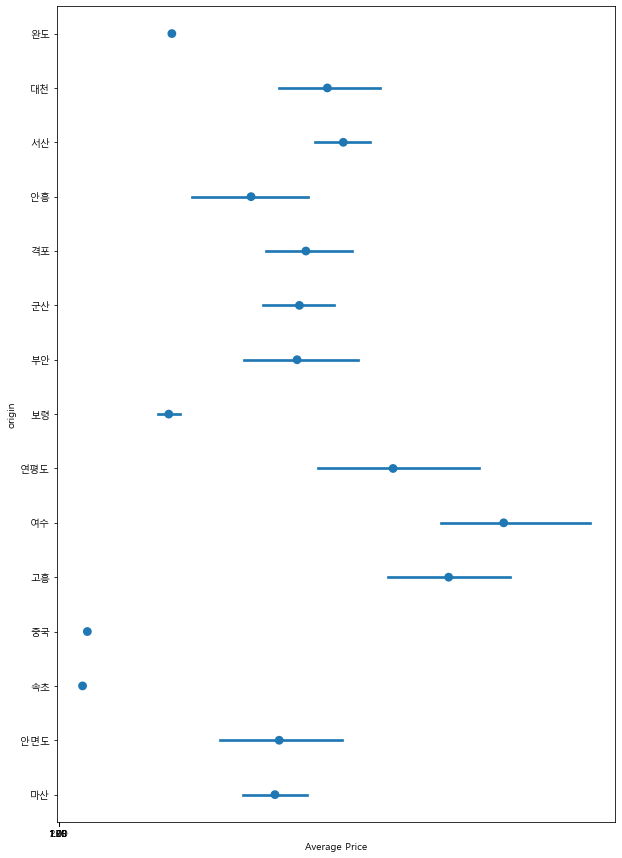

In [103]:
plt.rcParams['font.family']= 'Malgun Gothic'

plt.figure(figsize=(10, 15))
sns.pointplot(x='avg_price', y='origin', data=jb_pdf, join=False)
plt.xticks(np.linspace(1, 2, 5))
plt.xlabel('Average Price')
plt.ylabel('origin')

In [104]:
jb_pdf.head()

,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd
0,(활)전복,완도,10/11미,kg,78,1.0,43100,2017,1,2
1,(활)전복,완도,11/12미,kg,33,1.0,40200,2017,1,2
2,(활)전복,완도,12/13미,kg,145,1.0,37700,2017,1,2
3,(활)전복,완도,12미,kg,35,1.0,35000,2017,1,2
4,(활)전복,완도,13/14미,kg,124,1.0,36100,2017,1,2


In [105]:
jb_pdf['origin'].count()

31517

In [106]:
jb_pdf['origin'].value_counts()

완도     31341
서산        48
대천        35
군산        30
격포        13
안흥        12
안면도        8
보령         6
연평도        6
마산         5
부안         4
고흥         4
여수         3
중국         1
속초         1
Name: origin, dtype: int64

### 10자리 이하를 제외한 완도, 서산, 대천, 군산, 격포, 안흥만을 쿼리
-> 완도가 압도적으로 많이 차지하고 있어서 데이터 크게 편향적일 수 있음

In [107]:
origin_mask = (jb_pdf.origin == '완도')|(jb_pdf.origin == '서산')|(jb_pdf.origin == '대천')|(jb_pdf.origin == '군산')|(jb_pdf.origin == '격포')|(jb_pdf.origin == '안흥')

jb_pdf = jb_pdf.loc[origin_mask, :]

In [108]:
jb_pdf['origin'].value_counts()

완도    31341
서산       48
대천       35
군산       30
격포       13
안흥       12
Name: origin, dtype: int64

In [109]:
jb_pdf['standard'].value_counts()

12/13미    1620
13/14미    1611
11/12미    1601
14/15미    1598
15/16미    1591
          ... 
1미           1
2미           1
37미          1
10/12        1
85미          1
Name: standard, Length: 102, dtype: int64

In [111]:
jb_pdf[jb_pdf.standard=='12/13미']

,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd
2,(활)전복,완도,12/13미,kg,145,1.0,37700,2017,1,2
23,(활)전복,완도,12/13미,kg,181,1.0,34900,2017,1,3
45,(활)전복,완도,12/13미,kg,144,1.0,33900,2017,1,4
64,(활)전복,완도,12/13미,kg,311,1.0,30300,2017,1,5
85,(활)전복,완도,12/13미,kg,152,1.0,31000,2017,1,6
...,...,...,...,...,...,...,...,...,...,...
31969,(활)전복,완도,12/13미,kg,57,1.0,26800,2021,12,27
31989,(활)전복,완도,12/13미,kg,22,1.0,28000,2021,12,28
32009,(활)전복,완도,12/13미,kg,104,1.0,26700,2021,12,29
32030,(활)전복,완도,12/13미,kg,34,1.0,27700,2021,12,30


In [112]:
standard_mask = (jb_pdf.standard == '12/13미')|(jb_pdf.standard == '13/14미')|(jb_pdf.standard == '11/12미')|(jb_pdf.standard == '14/15미')


jb_pdf = jb_pdf.loc[standard_mask, :]

In [113]:
jb_pdf['standard'].value_counts()

12/13미    1620
13/14미    1611
11/12미    1601
14/15미    1598
Name: standard, dtype: int64

#### 추려낸 위 규격에서 가장 많은 포장을 차지하는 kg 포장으로 단일화

In [116]:
jb_pdf['unit'].value_counts()

kg       6394
S/P        17
가구         12
box         6
미(마리)       1
Name: unit, dtype: int64

In [118]:
jb_pdf = jb_pdf[jb_pdf.unit == 'kg']

In [119]:
jb_pdf.head(3)

,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd
1,(활)전복,완도,11/12미,kg,33,1.0,40200,2017,1,2
2,(활)전복,완도,12/13미,kg,145,1.0,37700,2017,1,2
4,(활)전복,완도,13/14미,kg,124,1.0,36100,2017,1,2


In [120]:
jb_pdf[jb_pdf.unit != 'kg']

,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd


In [121]:
jb_pdf = jb_pdf.drop(['species', 'unit'], axis=1)

jb_pdf.head()

,origin,standard,amount,weight,avg_price,yyyy,mm,dd
1,완도,11/12미,33,1.0,40200,2017,1,2
2,완도,12/13미,145,1.0,37700,2017,1,2
4,완도,13/14미,124,1.0,36100,2017,1,2
5,완도,14/15미,99,1.0,35000,2017,1,2
22,완도,11/12미,139,1.0,34700,2017,1,3


### 범주형 데이터 OHE 수행

In [122]:
jb_pdf = pd.get_dummies(jb_pdf, columns=['origin', 'standard'])

In [123]:
jb_pdf.head(3)

,amount,weight,avg_price,yyyy,mm,dd,origin_격포,origin_군산,origin_대천,origin_완도,standard_11/12미,standard_12/13미,standard_13/14미,standard_14/15미
1,33,1.0,40200,2017,1,2,0,0,0,1,1,0,0,0
2,145,1.0,37700,2017,1,2,0,0,0,1,0,1,0,0
4,124,1.0,36100,2017,1,2,0,0,0,1,0,0,1,0


In [126]:
len(jb_pdf.columns)

14

In [124]:
jb_pdf.describe()

,amount,weight,avg_price,yyyy,mm,dd,origin_격포,origin_군산,origin_대천,origin_완도,standard_11/12미,standard_12/13미,standard_13/14미,standard_14/15미
count,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000
mean,144.689865,1.006741,24296.027526,2018.946669,6.598061,15.711448,0.000156,0.000156,0.000626,0.999062,0.248827,0.251799,0.250547,0.248827
std,83.133829,0.254169,3411.869563,1.392299,3.368058,8.742243,0.012506,0.012506,0.025006,0.030621,0.432367,0.434080,0.433362,0.432367
min,1.000000,1.000000,13300.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,1.000000,22300.000000,2018.000000,4.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,135.000000,1.000000,24200.000000,2019.000000,7.000000,16.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,185.000000,1.000000,26200.000000,2020.000000,9.000000,23.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1873.000000,11.800000,101100.000000,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 시각화

In [127]:
num_cols = ['amount', 'weight', 'avg_price', 'yyyy', 'mm', 'dd']
num_jb_pdf = jb_pdf[num_cols]

<AxesSubplot:>

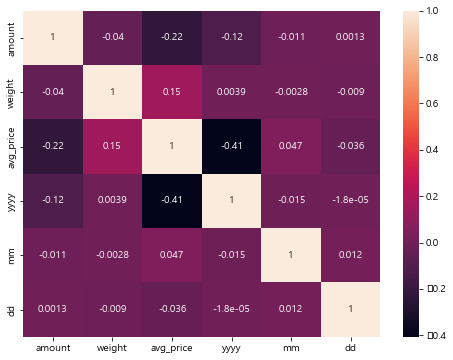

In [128]:
plt.figure(figsize=(8, 6))
sns.heatmap(num_jb_pdf.corr(), annot=True)

In [129]:
print(jb_pdf.columns)
print("컬럼 수 :", len(jb_pdf.columns))

Index(['amount', 'weight', 'avg_price', 'yyyy', 'mm', 'dd', 'origin_격포',
       'origin_군산', 'origin_대천', 'origin_완도', 'standard_11/12미',
       'standard_12/13미', 'standard_13/14미', 'standard_14/15미'],
      dtype='object')
컬럼 수 : 14


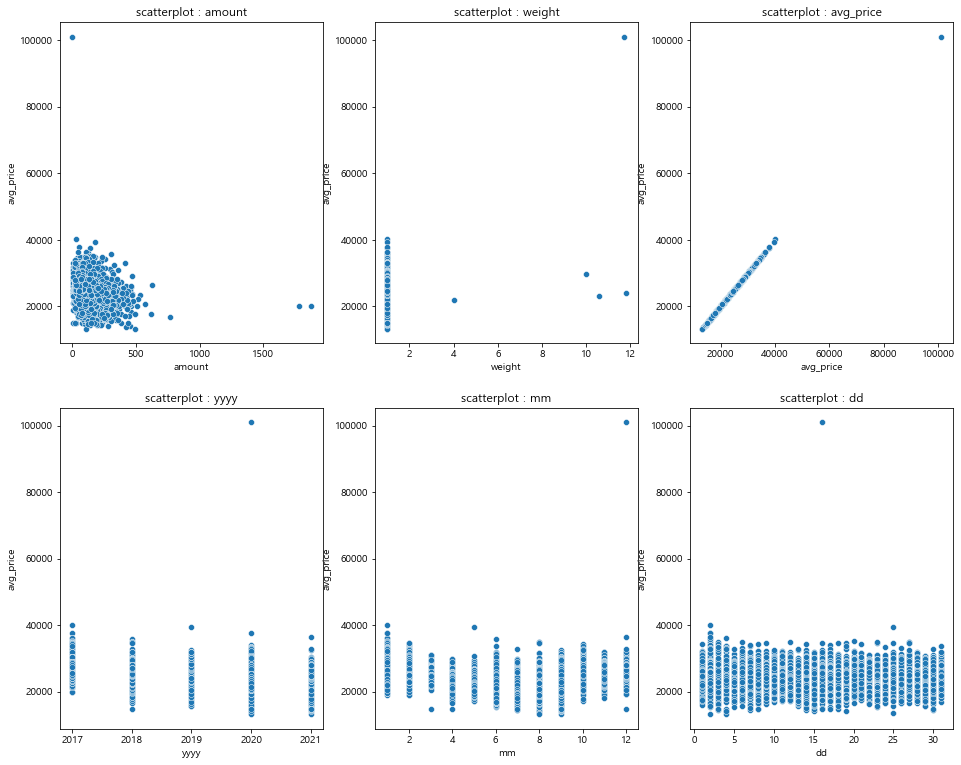

In [130]:
fig, ax = plt.subplots(nrows = 2, ncols =3)
fig.set_size_inches(16,13)
for i in range(len(num_jb_pdf.columns)):
    sns.scatterplot(data = num_jb_pdf, y = 'avg_price' ,x = num_jb_pdf.columns[i], ax= ax[int(i//3)][int(i%3)])
    ax[int(i//3)][int(i%3)].set_title("scatterplot : " + num_jb_pdf.columns[i])

plt.show()

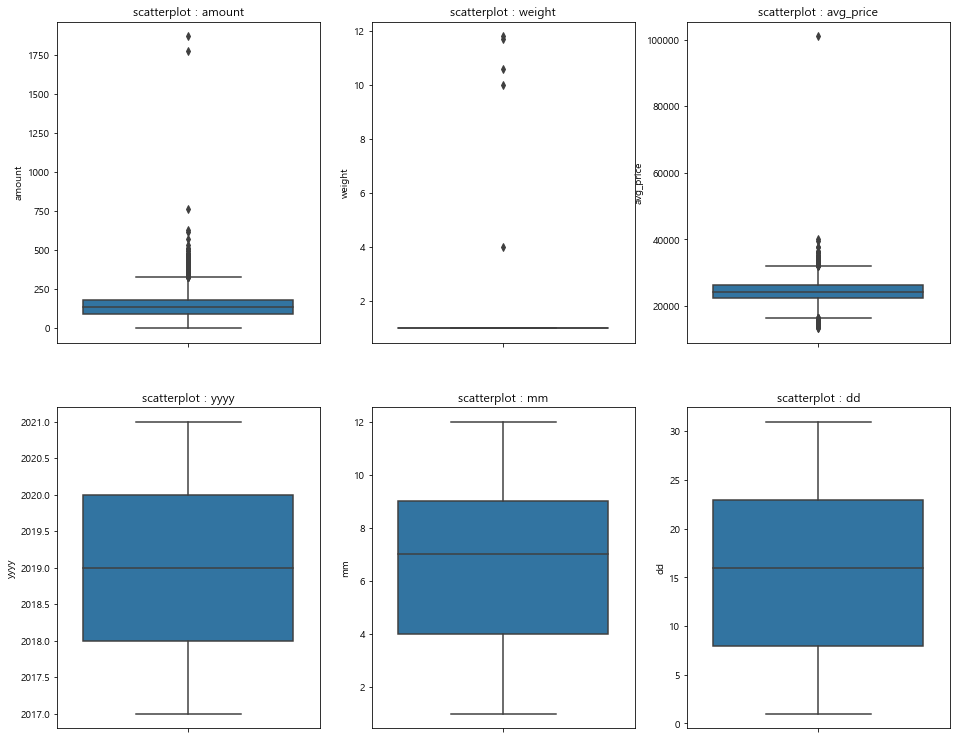

In [131]:
fig, ax = plt.subplots(nrows = 2, ncols =3)
fig.set_size_inches(16,13)
for i in range(len(num_jb_pdf.columns)):
    sns.boxplot(data = num_jb_pdf, y = num_jb_pdf.columns[i], ax= ax[int(i//3)][int(i%3)])
    ax[int(i//3)][int(i%3)].set_title("scatterplot : " + num_jb_pdf.columns[i])

plt.show()

### 결측치 제거

amout > 1000 이상 데이터 제거

In [132]:
jb_pdf['amount'].sort_values()

25750       1
3300        4
23596      10
31038      10
9167       10
         ... 
7962      617
8684      631
29374     767
30255    1779
30057    1873
Name: amount, Length: 6394, dtype: int32

In [134]:
jb_pdf = jb_pdf[jb_pdf.amount < 1000]

weight > 4 이상 데이터 제거

In [135]:
jb_pdf['weight'].sort_values()

1         1.0
21376     1.0
21362     1.0
21360     1.0
21358     1.0
         ... 
23738     4.0
1643     10.0
15886    10.6
25750    11.7
21097    11.8
Name: weight, Length: 6392, dtype: float64

In [145]:
jb_pdf = jb_pdf[jb_pdf.weight < 4]

avg_price는 위의 이상치 제거하면서 사라짐 -> 제거하지 않음

In [146]:
jb_pdf['avg_price'].sort_values()

29617    13300
24022    13300
23879    13700
23778    14200
23722    14200
         ...  
31558    36500
2        37700
19902    37800
16180    39500
1        40200
Name: avg_price, Length: 6387, dtype: int32

In [149]:
jb_pdf.count()

amount             6387
weight             6387
avg_price          6387
yyyy               6387
mm                 6387
dd                 6387
origin_격포          6387
origin_군산          6387
origin_대천          6387
origin_완도          6387
standard_11/12미    6387
standard_12/13미    6387
standard_13/14미    6387
standard_14/15미    6387
dtype: int64

## 선형 회귀

In [150]:
jb_pdf.head()

,amount,weight,avg_price,yyyy,mm,dd,origin_격포,origin_군산,origin_대천,origin_완도,standard_11/12미,standard_12/13미,standard_13/14미,standard_14/15미
1,33,1.0,40200,2017,1,2,0,0,0,1,1,0,0,0
2,145,1.0,37700,2017,1,2,0,0,0,1,0,1,0,0
4,124,1.0,36100,2017,1,2,0,0,0,1,0,0,1,0
5,99,1.0,35000,2017,1,2,0,0,0,1,0,0,0,1
22,139,1.0,34700,2017,1,3,0,0,0,1,1,0,0,0


In [151]:
X = jb_pdf.drop(columns='avg_price')
y = jb_pdf['avg_price']

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20, shuffle =True, test_size = 0.2)

In [153]:
jb_model_lr = LinearRegression()
jb_model_lr.fit(X_train, y_train)
jb_lr_y_pred = jb_model_lr.predict(X_test)

In [154]:
print(jb_model_lr.score(X_train, y_train))
print(jb_model_lr.score(X_test, y_test))

0.3666512711726564
0.4355898451420406


In [155]:
MSE = mean_squared_error(y_test, jb_lr_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, jb_lr_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 5987086.89332, RMSE : 2446.85245
r2_score :  0.4355898451420406


In [ ]:
y_test = np.array(y_test)

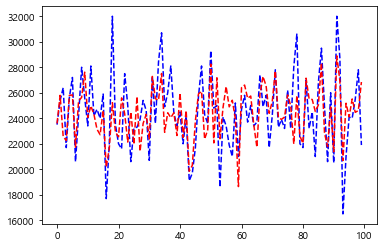

In [158]:
y_test = np.array(y_test)

real = []
pred = []
index = []

for i in range(100):
  index.append(i)
  real.append(y_test[i])
  pred.append(jb_lr_y_pred[i])
  
plt.plot(index, real, 'b--', label="Real")
plt.plot(index, pred, 'r--', label="Pred")
plt.show()

In [160]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
# minmax_scaler = MinMaxScaler()
scaler.fit(X_train)

x_train_scaled = scaler.transform(X_train)
x_test_scaled = scaler.transform(X_test)

In [161]:
jb_model_lr.fit(x_train_scaled, y_train)
jb_y_pred_scaled = jb_model_lr.predict(x_test_scaled)

In [162]:
MSE = mean_squared_error(y_test, jb_y_pred_scaled)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, jb_y_pred_scaled)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 5986544.12045, RMSE : 2446.74153
r2_score :  0.4356410130187749


## 랜덤포레스트

In [163]:
jb_model_rf = RandomForestRegressor()

jb_model_rf.fit(X_train, y_train)
jb_rf_y_pred = jb_model_rf.predict(X_test)

In [164]:
MSE = mean_squared_error(y_test, jb_rf_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, jb_rf_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 1452539.49609, RMSE : 1205.21346
r2_score :  0.8630672885609384


In [165]:
rf_parameters = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 6, 9, 12],
    # 'max_depth': [5, 6, 9, 12],
    # 'min_samples_split': [0.01, 0.02, 0.1, 0.15],
    # 'max_features': ['auto', 'sqrt'],
    'random_state':[99]
}

cv = KFold(n_splits=6)

rf = RandomForestRegressor()
rf_grid_cv = GridSearchCV(rf, param_grid=rf_parameters, cv=cv, n_jobs=-1, scoring='r2')
rf_grid_cv.fit(X_train, y_train)
 
 
print('최적 하이퍼 파라미터:', rf_grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(rf_grid_cv.best_score_))

최적 하이퍼 파라미터: {'max_depth': None, 'n_estimators': 250, 'random_state': 99}
최적 예측 정확도: 0.8216


In [166]:
jb_model_rf = rf_grid_cv.best_estimator_
jb_rf_y_pred = jb_model_rf.predict(X_test)

In [167]:
MSE = mean_squared_error(y_test, jb_rf_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, jb_rf_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 1426147.00995, RMSE : 1194.21397
r2_score :  0.8655553411734564


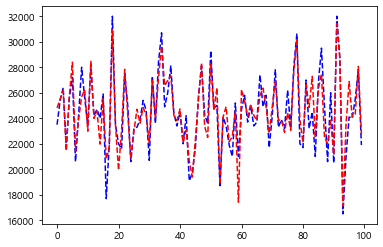

In [168]:
real = []
pred = []
index = []

for i in range(100):
  index.append(i)
  real.append(y_test[i])
  pred.append(jb_rf_y_pred[i])
  
plt.plot(index, real, 'b--', label="Real")
plt.plot(index, pred, 'r--', label="Pred")
plt.show()

## XGBRegressor

In [170]:
jb_model_xgb = XGBRegressor()

jb_model_xgb.fit(X_train, y_train)
jb_xgb_y_pred = jb_model_xgb.predict(X_test)

In [171]:
MSE = mean_squared_error(y_test, jb_xgb_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, jb_xgb_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 1539227.20489, RMSE : 1240.65596
r2_score :  0.8548951300434996


xgb에 gcv 해본 것

In [173]:
xg_parameters ={'max_depth' : [3,4,5,6] , 
                # 'n_estimators': [12,24,32], 
                'n_estimators': [100,200,300], 
                'learning_rate':[0.01, 0.1], 
                # 'learning_rate':[0.1, 0.3, 0.5], 
                'gamma': [1, 2, 4], 
                'random_state':[99]}

xgb = XGBRegressor()
xgb_grid_cv = GridSearchCV(xgb, param_grid=xg_parameters, cv=6, n_jobs=-1, scoring='r2')
xgb_grid_cv.fit(X_train, y_train)
 
 
print('최적 하이퍼 파라미터:', xgb_grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(xgb_grid_cv.best_score_))


최적 하이퍼 파라미터: {'gamma': 4, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'random_state': 99}
최적 예측 정확도: 0.8257


In [174]:
jb_model_xgb = xgb_grid_cv.best_estimator_
jb_xgb_y_pred = jb_model_xgb.predict(X_test)

In [175]:
MSE = mean_squared_error(y_test, jb_xgb_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, jb_xgb_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 1388570.85638, RMSE : 1178.37636
r2_score :  0.8690976920759605


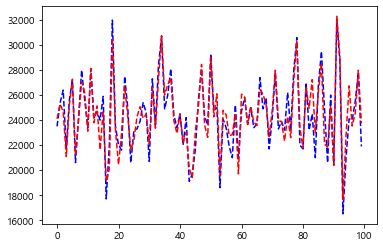

In [176]:
real = []
pred = []
index = []

for i in range(100):
  index.append(i)
  real.append(y_test[i])
  pred.append(jb_xgb_y_pred[i])
  
plt.plot(index, real, 'b--', label="Real")
plt.plot(index, pred, 'r--', label="Pred")
plt.show()

## lightGBM

In [177]:
jb_model_lgb = LGBMRegressor()

jb_model_lgb.fit(X_train, y_train)
jb_lgb_y_pred = jb_model_lgb.predict(X_test)

In [178]:
MSE = mean_squared_error(y_test, jb_lgb_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, jb_lgb_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 1558979.93629, RMSE : 1248.59118
r2_score :  0.8530330153982681


In [179]:
# lgb_parameters ={'max_depth' : [3,4,5,6] ,  
#                 'n_estimators': [100,300,500], 
#                 'learning_rate':[0.01, 0.05, 0.1],   
#                 'random_state':[99]}

lgb_parameters ={
    'n_estimators': [200, 500, 1000, 2000],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [6, 7, 8],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0] 
                }

lgb = LGBMRegressor()
lgb_grid_cv = GridSearchCV(lgb, param_grid=lgb_parameters, cv=6, n_jobs=-1, scoring='r2')
lgb_grid_cv.fit(X_train, y_train)
 
 
print('최적 하이퍼 파라미터:', lgb_grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(lgb_grid_cv.best_score_))

최적 하이퍼 파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
최적 예측 정확도: 0.8338


In [180]:
jb_model_lgb = lgb_grid_cv.best_estimator_
jb_lgb_y_pred = jb_model_lgb.predict(X_test)

In [181]:
MSE = mean_squared_error(y_test, jb_lgb_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, jb_lgb_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 1418035.10197, RMSE : 1190.81279
r2_score :  0.8663200608650123


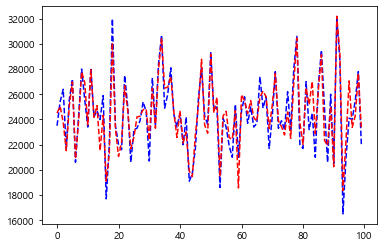

In [182]:
real = []
pred = []
index = []

for i in range(100):
  index.append(i)
  real.append(y_test[i])
  pred.append(jb_lgb_y_pred[i])
  
plt.plot(index, real, 'b--', label="Real")
plt.plot(index, pred, 'r--', label="Pred")
plt.show()